In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from calibrated_explanations import CalibratedExplainer, VennAbers, __version__
from sklearn.utils import shuffle
import copy
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer
from shap import Explainer
import time

print(f"calibrated_explanations v. {__version__}")


c:\Users\loftuw\Anaconda3\envs\cp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


calibrated_explanations v. v0.0.5


In [3]:
dataSet = 'diabetes_full'
delimiter = ','
num_to_test = 2
model = 'RF'
print(dataSet)

fileName = '../data/' + dataSet + ".csv"
df = pd.read_csv(fileName, delimiter=delimiter)
# df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", header=None)
# df = df.replace({"?": 0})
df.head()

diabetes_full


Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Y  
0                     0.627   50  1  
1                     0.351   31  0  
2                     0.672   32  1  
3                     0.167   21  0  
4                     2.288   33  1

In [4]:
target = 'Y'
X, y = df.drop(target,axis=1), df[target] 
no_of_classes = len(np.unique(y))
no_of_features = X.shape[1]
no_of_instances = X.shape[0]
categorical_features = [i for i in range(no_of_features) if len(np.unique(X.iloc[:,i])) < 10]
# # sort targets to make sure equal presence of both classes in test set (see definition of test_index after outer loop below)
idx = np.argsort(y.values).astype(int)
X, y = X.values[idx,:], y.values[idx]
# Select num_to_test/2 from top and num_to_test/2 from bottom of list of instances
test_index = np.array([*range(int(num_to_test/2)), *range(no_of_instances-1, no_of_instances-int(num_to_test/2)-1,-1)])
train_index = np.setdiff1d(np.array(range(no_of_instances)), test_index)   
trainCalX, testX = X[train_index,:], X[test_index,:]
trainCalY, testY = y[train_index], y[test_index]
# trainCalX,trainCalY = shuffle(trainCalX, trainCalY)
trainX, calX, trainY, calY = train_test_split(trainCalX, trainCalY, test_size=0.33,random_state=42, stratify=trainCalY)
print(testY)
print(categorical_features)

[0 1]
[]


In [5]:
t1 = DecisionTreeClassifier()
r1 = RandomForestClassifier(n_estimators=100)

model_dict = {'RF':(r1,"RF"),'DT': (t1,"DT")}
model, model_name = model_dict[model] 
model.fit(trainX,trainY)  


RandomForestClassifier()

In [6]:

va = VennAbers(calX, calY, model)
va_preds = va.predict(testX)
va_proba, low, high = va.predict_proba(testX, output_interval=True)
print(*zip(low, va_proba[:,1],high, va_preds,testY),sep='\n')  

(0.0, 0.03278688524590164, 0.03389830508474576, 0.0, 0)
(0.8, 0.8203125000000001, 0.9130434782608695, 1.0, 1)


In [7]:
ce = CalibratedExplainer(model, copy.deepcopy(calX), copy.deepcopy(calY), \
                    feature_names=df.columns, \
                    # preload_SHAP=True, preload_LIME=True, \
                    categorical_features=categorical_features, class_labels={0:'Non-diabetic',1:'Diabetic'})


1.0192456245422363


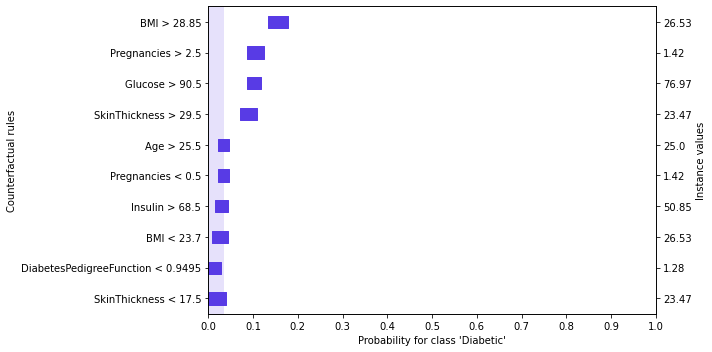

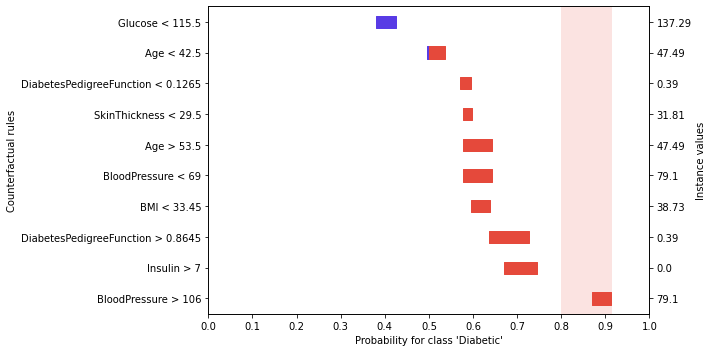

In [8]:

# num_neighbors  = 1.0 :#.5,.75,
#     ce.set_num_neighbors(num_neighbors)
discretizer = 'entropy'#,,]:#'entropy','quartile','decile','binary',
ce.set_discretizer(discretizer)
tic = time.time()
exp = ce(copy.deepcopy(testX))
print(time.time()-tic)
# exp.add_conjunctive_counterfactual_rules()
exp.plot_counterfactuals(title=dataSet + ' counterfactuals ' + discretizer, num_to_show=10, path='plots/', save_ext=[])


0.7845103740692139


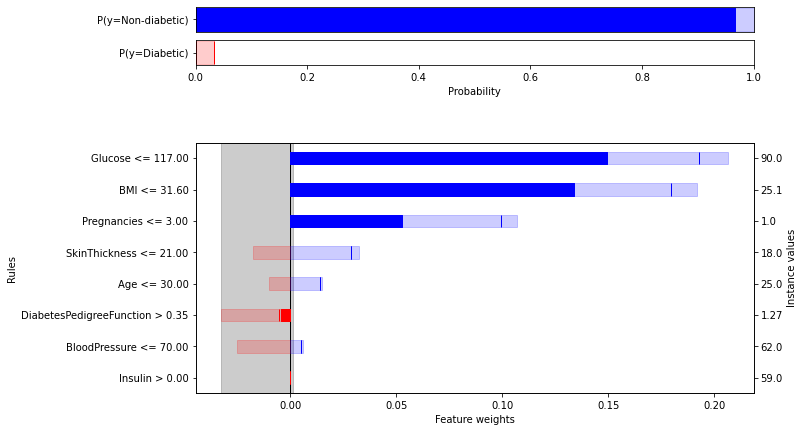

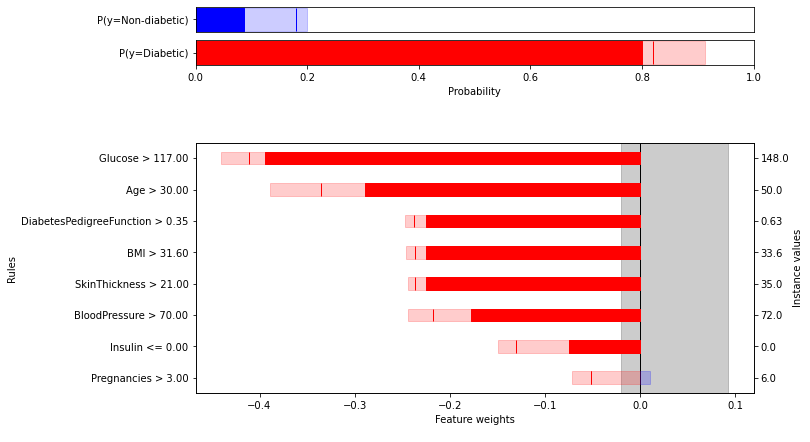

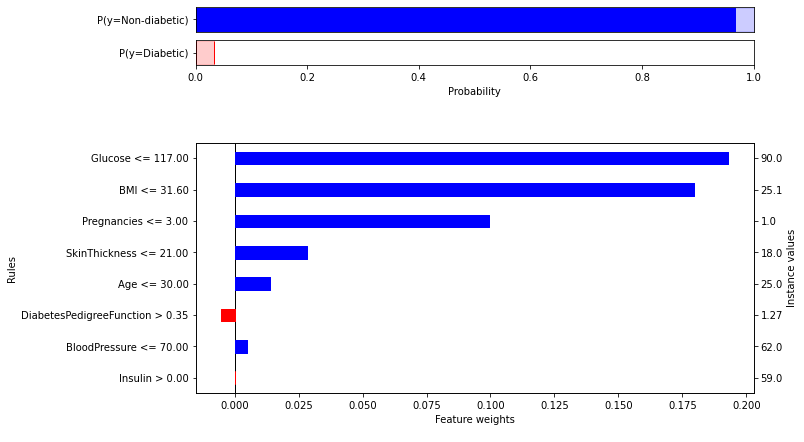

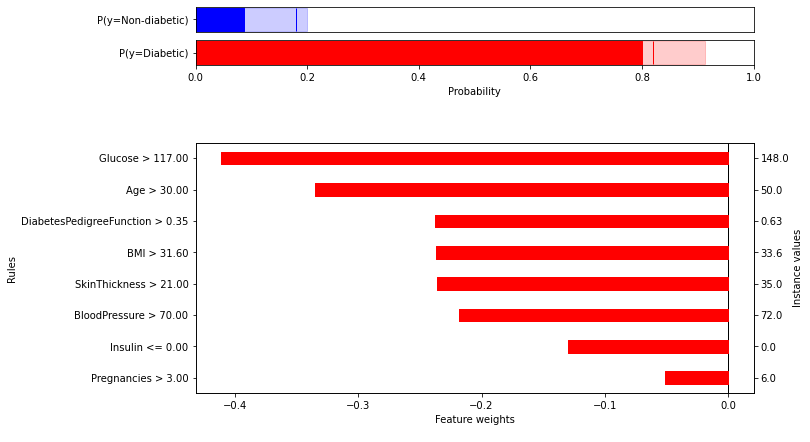

In [9]:

discretizer = 'binary'#,,]:#'entropy','quartile','decile','binary',
ce.set_discretizer(discretizer)
tic = time.time()
exp = ce(copy.deepcopy(testX))
print(time.time()-tic)
# exp.add_conjunctive_factual_rules()
# print(ce.num_neighbors)
exp.plot_uncertainty(title=dataSet + ' interval ' + discretizer, num_to_show=10, save_ext=[])
exp.plot_regular(title=dataSet + ' simple ' + discretizer, num_to_show=10, save_ext=[])
# print(exp.x)

0.7660417556762695


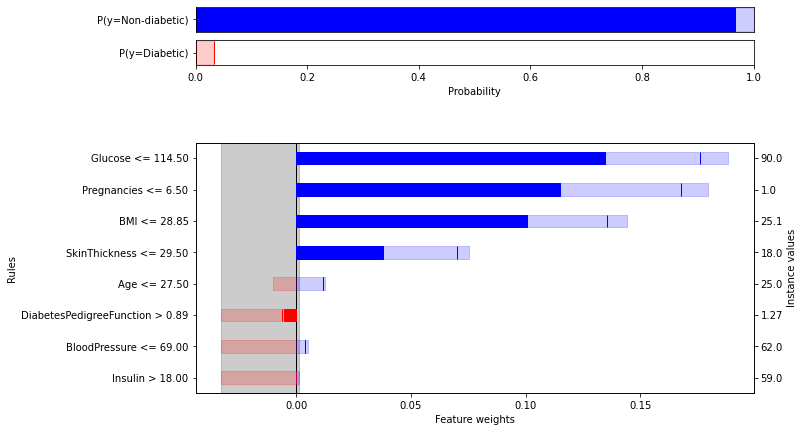

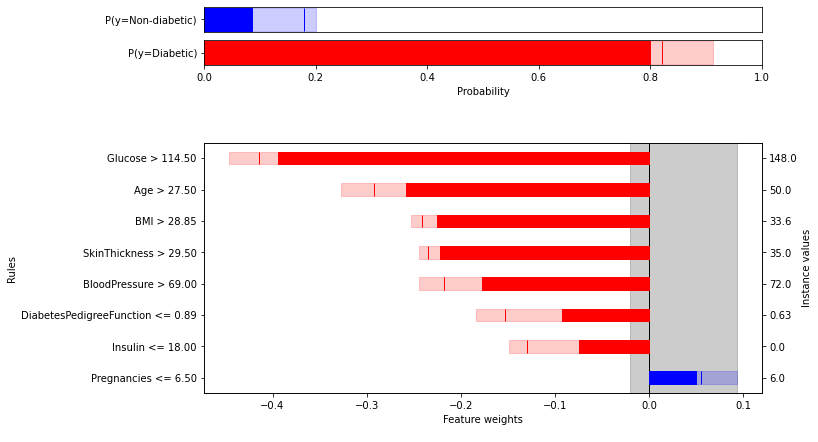

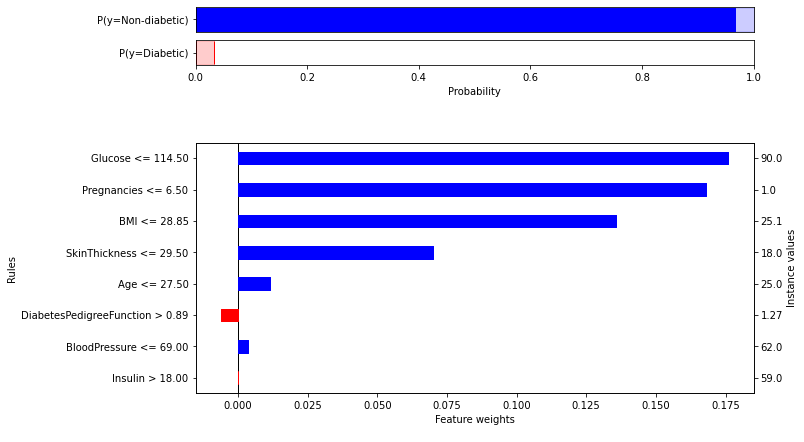

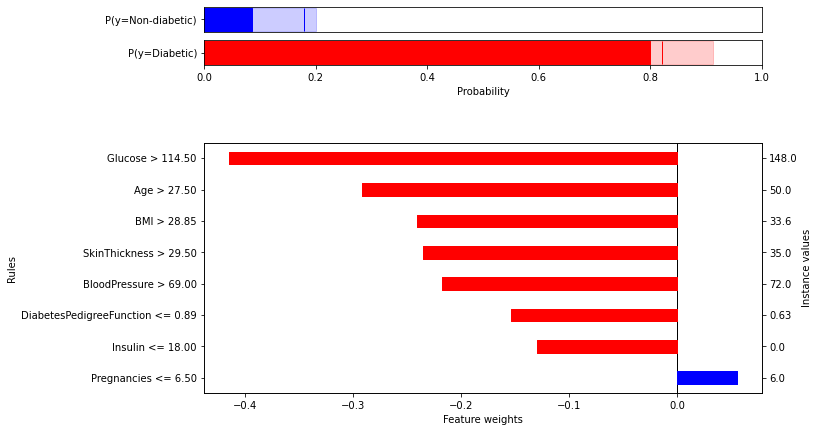

In [10]:

discretizer = 'binaryEntropy'#,,]:#'entropy','quartile','decile','binary',
ce.set_discretizer(discretizer)
tic = time.time()
exp = ce(copy.deepcopy(testX))
print(time.time()-tic)
# exp.add_conjunctive_counterfactual_rules()
# print(ce.num_neighbors)
exp.plot_uncertainty(title=dataSet + ' interval ' + discretizer, num_to_show=10, save_ext=[])
exp.plot_regular(title=dataSet + ' simple ' + discretizer, num_to_show=10, save_ext=[])
# print(exp.x)

In [11]:

discretizer = 'entropy'#,,]:#'entropy','quartile','decile','binary',
ce.set_discretizer(discretizer)
tic = time.time()
exp = ce(copy.deepcopy(testX))
toc = time.time()
print(toc-tic)

1.0069093704223633


In [ ]:
for i in range(5):
    tic = time.time()
    exp = exp.add_conjunctive_counterfactual_rules(num_to_include=i+2)#(-np.inf,90))#(10,np.inf))#
    toc = time.time()
    print(toc-tic)

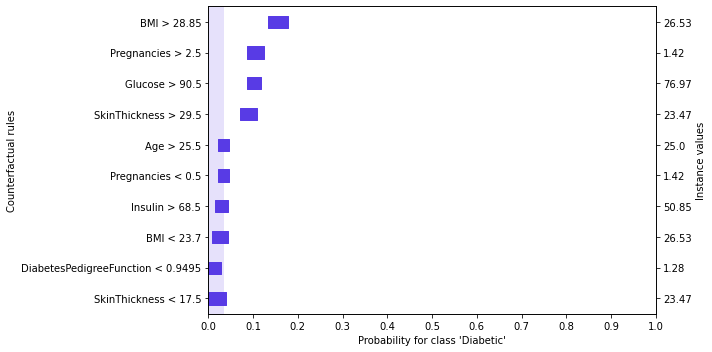

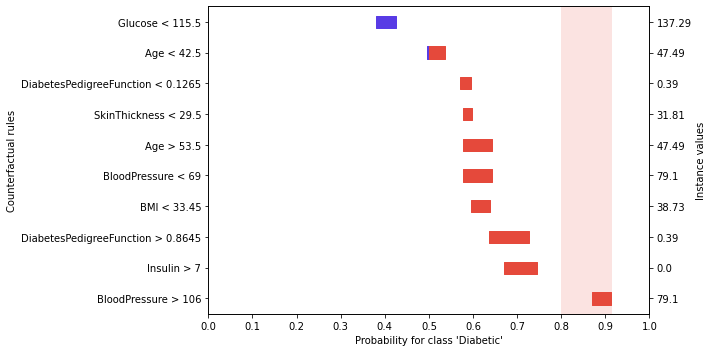

In [12]:
exp.plot_counterfactuals(title=dataSet + ' counterfactuals conjunctive' + discretizer, num_to_show=10, path='plots/', save_ext=[])

In [13]:
# Running the exp 20 times and saving the results

stability = {'predict':[],'low':[],'high':[]} 
for i in range (20):
    ce.set_random_state(i)
    exp = ce(copy.deepcopy(testX))
    stability['predict'].append(exp.feature_weights['predict'][1][:])
    stability['low'].append(exp.feature_weights['low'][1][:])
    stability['high'].append(exp.feature_weights['high'][1][:])


In [14]:

print(np.array(stability['predict'][0]))
print(*zip(np.array(stability['predict']).min(axis=0,),np.array(stability['predict']).max(axis=0,)),sep='\n')

[ 0.00163941 -0.17828666 -0.08165311 -0.13408652 -0.12993331 -0.20957236
 -0.19628149 -0.26055211]
(0.001639410621761539, 0.001639410621761539)
(-0.1782866556413839, -0.1782866556413839)
(-0.08165310944954618, -0.08165310944954618)
(-0.13408652278721245, -0.13408652278721245)
(-0.12993330583058305, -0.12993330583058305)
(-0.20957235621817993, -0.20957235621817993)
(-0.19628149224806213, -0.19628149224806213)
(-0.2605521138751373, -0.2605521138751373)


In [15]:
ce_as_lime = exp.as_lime()
for e in ce_as_lime:
    e.show_in_notebook(show_table=True)

In [16]:
lime = LimeTabularExplainer(calX,training_labels=calY, feature_names=df.columns, class_names=['Negative','Positive'], mode='classification')
lime_weights = []
for x in testX:
    exp_lime = lime.explain_instance(x, va.predict_proba, num_features=no_of_features)
    exp_lime.show_in_notebook(show_table=True, show_all=False)
    feature_order = [exp_lime.local_exp[1][f][0] for f in range(no_of_features)]
    lime_values = np.zeros(no_of_features)
    for i, f in enumerate(feature_order):
        lime_values[f] = exp_lime.local_exp[1][i][1]
    lime_weights.append([exp_lime.local_exp[1][exp_lime.local_exp[1][f][0]][1] for f in range(no_of_features)])
print(lime_weights, sep='\n')

[[-0.1862865676155827, -0.02580891467650001, -0.02552048570293577, -0.0398035581385513, 0.01188622081100817, -0.04352282039392541, -0.19439632735601806, 0.06700282292594573], [0.09283350751457292, -0.0025287950906367545, -0.017046459347122147, -0.03110834800935821, 0.06647126212553828, 0.03962309974764314, 0.07050257823399893, 0.2682485568591176]]


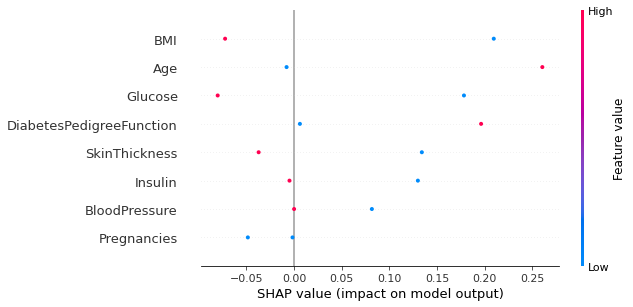

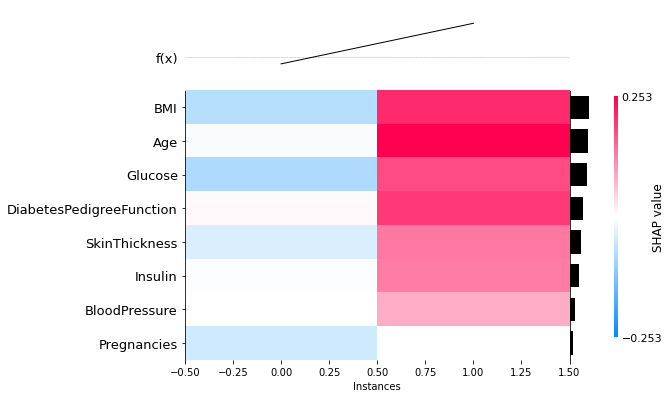

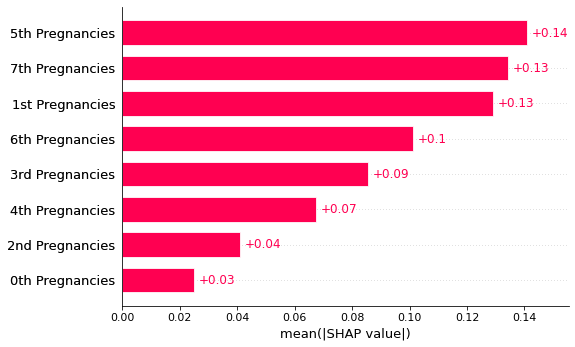

In [17]:
ce_as_shap = exp.as_shap()

from shap.plots import waterfall, force, scatter, heatmap, bar, violin, beeswarm
beeswarm(ce_as_shap)
# force(ce_as_shap[0])
heatmap(ce_as_shap)
bar(ce_as_shap)
# for e in ce_as_shap:
#     e.feature_names = ce_as_shap.feature_names
#     waterfall(e)
# scatter(ce_as_shap)

Exact explainer: 3it [00:38, 19.00s/it]               


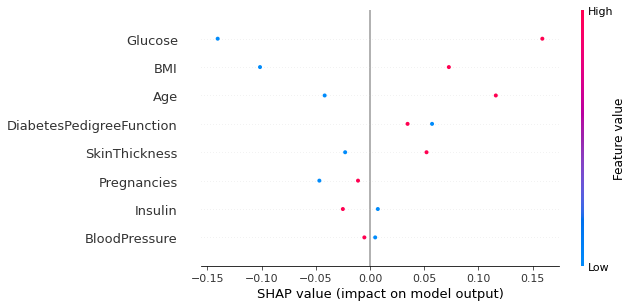

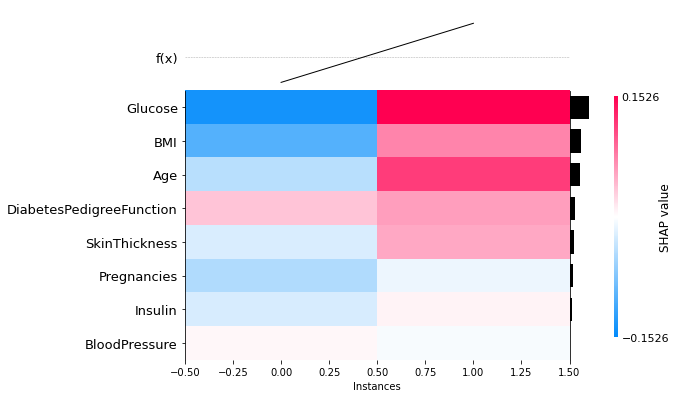

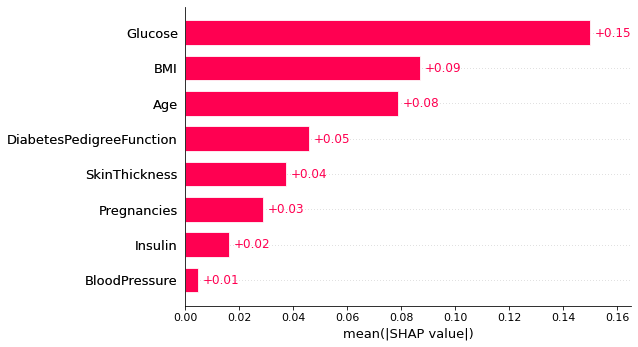

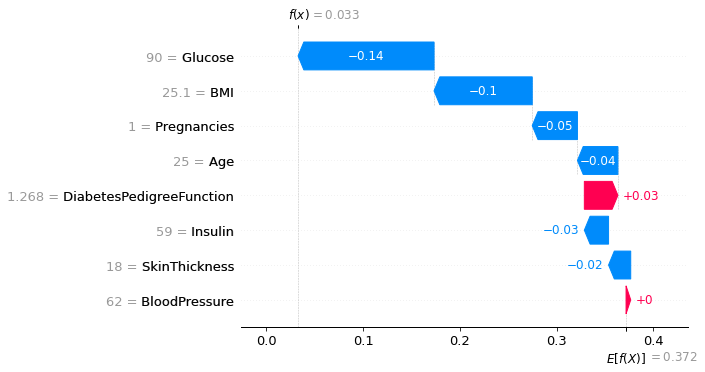

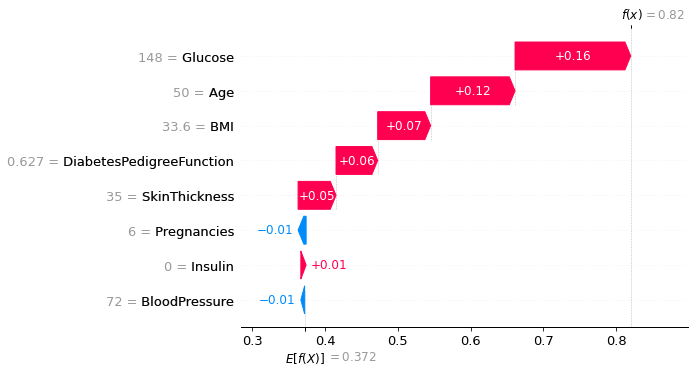

IndexError: too many indices for array

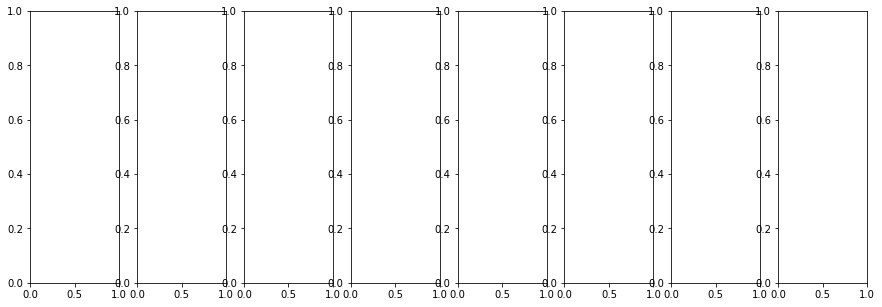

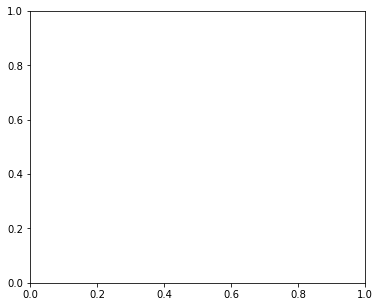

In [18]:
f = lambda x: va.predict_proba(x)[:,1]
shap = Explainer(f, calX, feature_names=df.columns)
shap_exp = shap(testX)
# shap_weights = shap_exp.values[:,:,1]
# print(shap_weights)
from shap.plots import waterfall, force, scatter, heatmap, bar, violin, beeswarm
beeswarm(shap_exp)
heatmap(shap_exp)
bar(shap_exp)
for e in shap_exp:
    waterfall(e)
# force(shap_exp[0])
scatter(shap_exp)
# violin(shap_exp)
